In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

plt.style.use('dark_background')

# some global variables for styling:
red    = '#f54242'
orange = '#f7993b'
yellow = '#ffe359'
green  = '#a2f781'
blue   = '#42daf5'
purple = '#d170fa'

### 1. Loading the data

In [41]:
with open('eda_config.yaml') as infile:
    config = yaml.safe_load(infile)

In [42]:
df = pd.read_csv(config['seh_data'], sep=';',  na_values=['', 'nan'])

# for some reason nan values cannot be changed to real NaN values when reading in the file, so I had to do it manually (for now)
df.replace('nan', np.nan, inplace=True)
df = df[~df['BESTEMMING'].isna()]
df['OPNAME'] = df['BESTEMMING'].apply(lambda x: 1 if x == 'OPN' else 0)

In [43]:
# df.head()

In [44]:
df.dtypes

SEHID                      int64
GESLACHT                  object
LEEFTIJD                 float64
AANKSDATUM                object
AANKSTIJD                 object
VVCODE                    object
KLACHT                    object
TRIANIVCOD                object
SPECIALISM                object
BESTEMMING                object
TRAUMA                     int64
PATGEZIEN                  int64
NurseHasCompletedActs      int64
OPNAME                     int64
dtype: object

Some column types are not correct.

In [45]:
df['AANKSDATUM'] = pd.to_datetime(df['AANKSDATUM'])

### EDA

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226747 entries, 1 to 229017
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   SEHID                  226747 non-null  int64         
 1   GESLACHT               226747 non-null  object        
 2   LEEFTIJD               226502 non-null  float64       
 3   AANKSDATUM             226502 non-null  datetime64[ns]
 4   AANKSTIJD              226507 non-null  object        
 5   VVCODE                 52092 non-null   object        
 6   KLACHT                 226588 non-null  object        
 7   TRIANIVCOD             215148 non-null  object        
 8   SPECIALISM             226197 non-null  object        
 9   BESTEMMING             226747 non-null  object        
 10  TRAUMA                 226747 non-null  int64         
 11  PATGEZIEN              226747 non-null  int64         
 12  NurseHasCompletedActs  226747 non-null  int6

#### Geslacht

M    114346
V    112399
O         2
Name: GESLACHT, dtype: int64


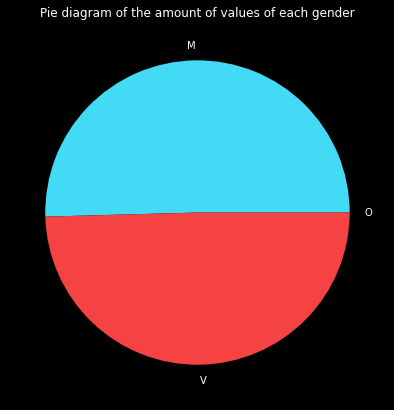

In [47]:
val_counts = df['GESLACHT'].value_counts(dropna=False)
print(val_counts)

plt.figure(figsize=(7, 7))
plt.title('Pie diagram of the amount of values of each gender')
plt.pie(val_counts, labels=val_counts.keys(), colors=[blue, red, yellow])
plt.show()

Classes are balanced, almost the same number of males as females.  
We also see that of three records the gender is unknown.   
Lets see what these records are.

In [48]:
df[df['GESLACHT'] == 'O']['KLACHT']

184339               niet geweest
202714    test functioneel beheer
Name: KLACHT, dtype: object

We can delete these entries, because theyre either a test or does not contain information.

In [49]:
df = df[df['GESLACHT'] != 'O']
df['GESLACHT'].unique()

array(['V', 'M'], dtype=object)

We can see if the OPNAME is also balanced in the classes.

GESLACHT  OPNAME
M         0         69301
          1         45045
V         0         68185
          1         44214
Name: OPNAME, dtype: int64


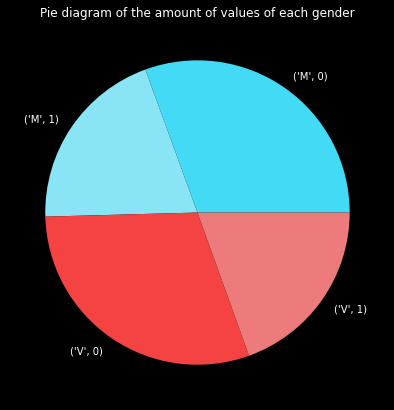

In [50]:
val_counts = df['OPNAME'].groupby(df['GESLACHT']).value_counts(dropna=False)
print(val_counts)

plt.figure(figsize=(7, 7))
plt.title('Pie diagram of the amount of values of each gender')
plt.pie(val_counts, labels=val_counts.keys(), colors=[blue, '#89e5f5', red,  '#ed7b7b'])
plt.show()

There are fewer admissions in both female and male.  
However, the distribution is very similar when comparing male to female.  

#### Leeftijd

In [51]:
df['LEEFTIJD'].isna().sum()

244

In [53]:
df['LEEFTIJD'].describe()

count    226501.000000
mean         52.313985
std          25.358497
min           0.000000
25%          30.000000
50%          56.000000
75%          74.000000
max         123.000000
Name: LEEFTIJD, dtype: float64

The dataset contains data ranging from 0 to 123, with a mean age of 52 years old.

In [54]:
def make_stacked_histogram(df, column, binning, title, xlabel, bar_width, figsize=(10, 7), date=False):
    colors = [blue, red]

    plt.figure(figsize=figsize)
    plt.title(title)
    plt.ylabel('Frequency')
    plt.xlabel(xlabel)

    bottom = 0
    for i, categorie in enumerate(df['OPNAME'].unique()):
        subset = df[df['OPNAME'] == i][column]
        hist_values, _, _ = plt.hist(subset, bins=binning, width=bar_width, color=colors[i], bottom=bottom, label=categorie)
        bottom = hist_values  # start value, so that it is stacked

    if not date:
        plt.xticks(binning)
    else:
        plt.gcf().autofmt_xdate()

    plt.grid(alpha=.2)
    plt.legend(labels=['Discharged', 'Admitted'], loc='best')
    plt.show()


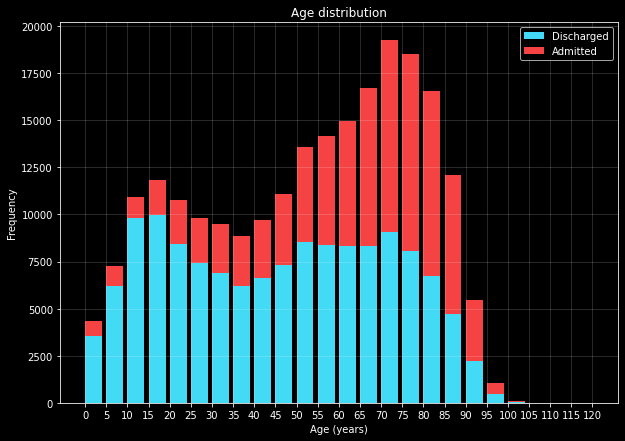

In [55]:
make_stacked_histogram(df, 'LEEFTIJD', [age for age in range(0, 125, 5)], 'Age distribution', 'Age (years)', 4)

You can see that more records are available for older people.   
This makes sense, because older people usually have more increased health issues, are more fragile and have reduced physiologocial reserves.  
A sharp decline can be seen when looking after the peak at the range of 70 - 85.
This can be explained by the fact that there are smaller number of individuals still alive in the age group above 85.   
You can also create a stacked barchart from it.

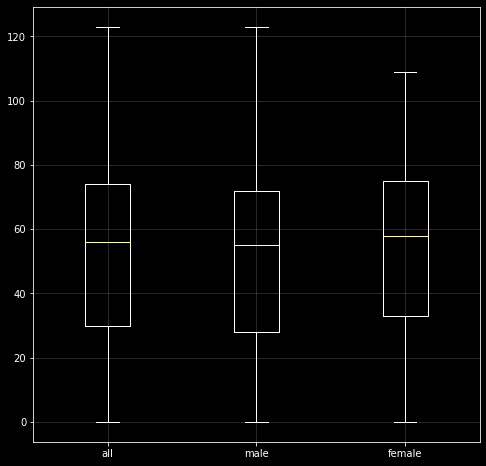

In [56]:
age_all = df['LEEFTIJD'].dropna()
age_male =  df[df.GESLACHT == 'M']['LEEFTIJD'].dropna()
age_female =  df[df.GESLACHT == 'V']['LEEFTIJD'].dropna()

plt.figure(figsize=(8, 8))
plt.boxplot([age_all, age_male, age_female], labels=['all', 'male', 'female'])
plt.grid(alpha=.2)
plt.show()

#### Datum

In [57]:
df['AANKSDATUM'].describe(datetime_is_numeric=True)

count                           226501
mean     2019-09-11 03:32:05.347791104
min                2015-10-11 00:00:00
25%                2017-08-29 00:00:00
50%                2019-08-22 00:00:00
75%                2021-09-30 00:00:00
max                2023-09-05 00:00:00
Name: AANKSDATUM, dtype: object

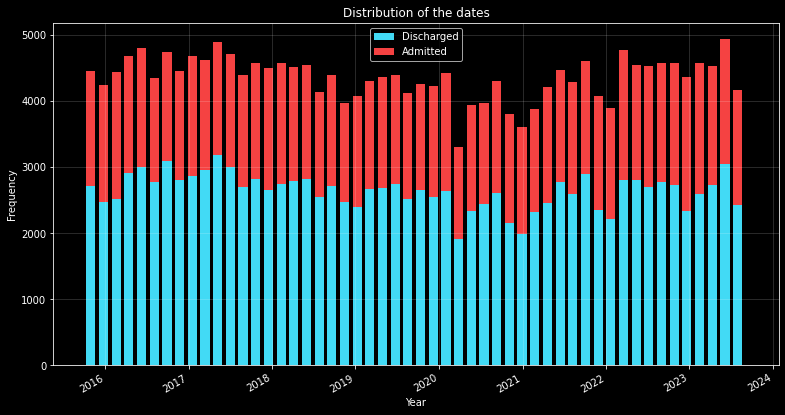

In [58]:
colors = [blue, red]

plt.figure(figsize=(13, 7))
plt.title('Distribution of the dates')
plt.xlabel('Year')
plt.ylabel('Frequency')

bottom = 0
for i, categorie in enumerate(df['OPNAME'].unique()):
    subset = df[df['OPNAME'] == i]['AANKSDATUM']
    hist_values, _, _ = plt.hist(subset, bins=52, range=(subset.min(), subset.max()), color=colors[i], width=40, label=categorie, bottom=bottom)
    bottom = hist_values  # start value, so that it is stacked next time


plt.gcf().autofmt_xdate()

plt.grid(alpha=.2)
plt.legend(labels=['Discharged', 'Admitted'], loc='best')
plt.show()


The distriubtion seems continues, with a small 'dip' at the start of 2020.  
This is when the Corona pandemic started, therefore less people where getting out of their houses and less people were getting in an accident.  
From 2022 the number of visitis seem to be back up at the normal.  
Other than that nothing really remarkable stands out.

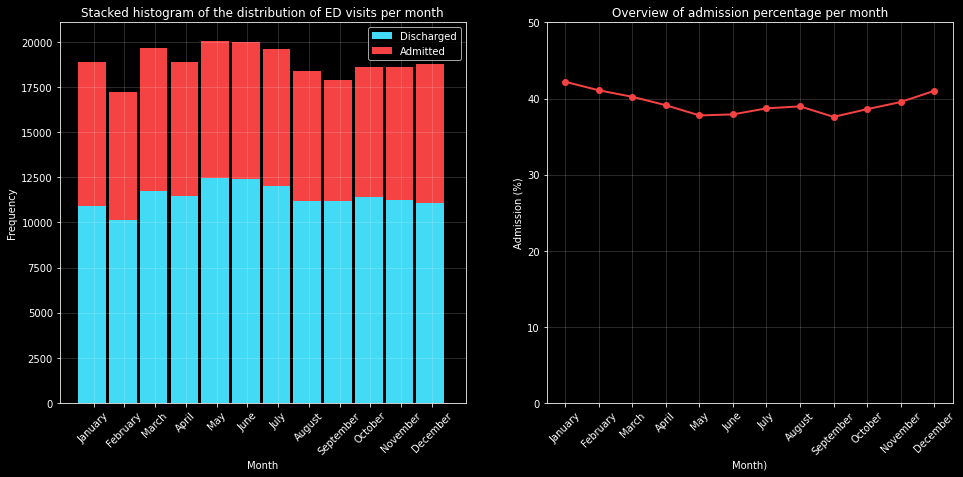

In [59]:
import calendar

plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
plt.title('Stacked histogram of the distribution of ED visits per month')
plt.xlabel('Month')
plt.ylabel('Frequency')
# plt.hist(pd.to_datetime(df['AANKSTIJD'],format= '%H:%M').dt.motnh, bins=range(0, 25), color=red, align='mid', width=0.8)
# plt.show()
bottom = 0
for i, categorie in enumerate(df['OPNAME'].unique()):
    subset = df[df['OPNAME'] == i]['AANKSDATUM']
    subset = subset.dt.month
    hist_values, _, _ = plt.hist(subset, bins=range(1, 14), width=0.9, label=categorie, bottom=bottom, color=colors[i], align='left')
    bottom = hist_values  # start value, so that it is stacked next time

plt.xticks(range(1, 13), calendar.month_name[1:], rotation=45)
plt.grid(alpha=.2)
plt.legend(labels=['Discharged', 'Admitted'], loc='best')

df_months = pd.DataFrame([df['AANKSDATUM'].dt.month, df['OPNAME']]).T
value_counts = df_months.groupby(['AANKSDATUM', 'OPNAME']).size().unstack(fill_value=0)
# calculate the percentage for each 'OPNAME' category within each 'AANKSTIJD' category
percentage_per_month = value_counts.div(value_counts.sum(axis=1), axis=0) * 100

plt.subplot(1, 2, 2)
plt.plot(percentage_per_month[1], 'o-', color=red, linewidth=2)
plt.title('Overview of admission percentage per month')
plt.ylim(0, 50)
plt.xlabel('Month)')
plt.xticks(range(1, 13), calendar.month_name[1:], rotation=45)
plt.ylabel('Admission (%)')
plt.grid(alpha=.2)
plt.show()

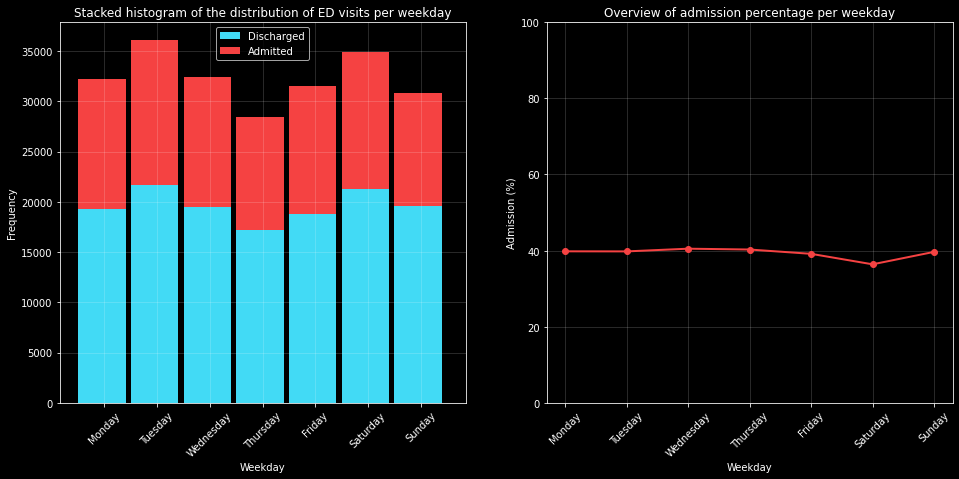

In [60]:

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
plt.title('Stacked histogram of the distribution of ED visits per weekday')
plt.xlabel('Weekday')
plt.ylabel('Frequency')

bottom = 0
for i, categorie in enumerate(df['OPNAME'].unique()):
    subset = df[df['OPNAME'] == i]['AANKSDATUM']
    subset = subset.dt.strftime("%A").dropna()
    hist_values, _, _ = plt.hist(subset, bins=range(8), width=0.9, label=i, bottom=bottom, color=colors[i], align='left')
    bottom = hist_values  # start value, so that it is stacked next time

plt.xticks(range(7), weekdays, rotation=45)
plt.grid(alpha=.2)
plt.legend(labels=['Discharged', 'Admitted'], loc='best')

df_weekdays = pd.DataFrame([df['AANKSDATUM'].dt.strftime('%A').dropna(), df['OPNAME']]).T
value_counts = df_weekdays.groupby(['AANKSDATUM', 'OPNAME']).size().unstack(fill_value=0).reindex(weekdays)
percentage_per_weekday = value_counts.div(value_counts.sum(axis=1), axis=0) * 100

plt.subplot(1, 2, 2)
plt.plot(percentage_per_weekday[1], 'o-', color=red, linewidth=2)
plt.title('Overview of admission percentage per weekday')
plt.ylim(0, 100)
plt.xlabel('Weekday')
plt.xticks(range(7), weekdays, rotation=45)
plt.ylabel('Admission (%)')
plt.grid(alpha=.2)
plt.show()


#### Tijd

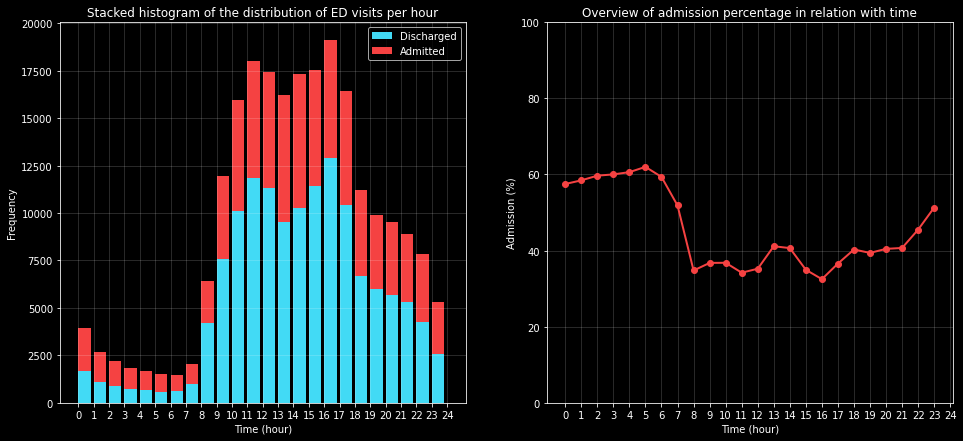

In [61]:
plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
plt.title('Stacked histogram of the distribution of ED visits per hour')
plt.xlabel('Time (hour)')
plt.ylabel('Frequency')

bottom = 0
for i, categorie in enumerate(df['OPNAME'].unique()):
    subset = df[df['OPNAME'] == i]['AANKSTIJD']
    subset = pd.to_datetime(subset,format= '%H:%M').dt.hour
    hist_values, _, _ = plt.hist(
        subset,
        bins=range(25),
        width=0.8,
        label=categorie,
        bottom=bottom,
        color=colors[i],
    )
    bottom = hist_values  # start value, so that it is stacked next time

plt.xticks(list(range(25)))
plt.grid(alpha=.2)
plt.legend(labels=['Discharged', 'Admitted'], loc='best')

# get Time data with respect to admission
df_time = pd.DataFrame([pd.to_datetime(df['AANKSTIJD'],format= '%H:%M').dt.hour, df['OPNAME']]).T
value_counts = df_time.groupby(['AANKSTIJD', 'OPNAME']).size().unstack(fill_value=0)
# calculate the percentage for each 'OPNAME' category within each 'AANKSTIJD' category
percentage_per_hour = value_counts.div(value_counts.sum(axis=1), axis=0) * 100

plt.subplot(1, 2, 2)
plt.plot(percentage_per_hour[1], 'o-', color=red, linewidth=2)
plt.title('Overview of admission percentage in relation with time')
plt.ylim(0, 100)
plt.xlabel('Time (hour)')
plt.xticks(list(range(25)))
plt.ylabel('Admission (%)')
plt.grid(alpha=.2)
plt.show()

_Headsup: Hour 13 means every Time starting with 13, so 13.00 to 14.00 (for example 13.55 also falls in this categorie)._

You can see that most ED visits are during the day.  
This is logical because people are sleeping during the night and therefore less people are in accidents or notice health issues.

#### VVCode

NaN     174654
AMB      39783
EV       12245
AND         35
HELI        21
AMBH         5
AMBG         2
Name: VVCODE, dtype: int64


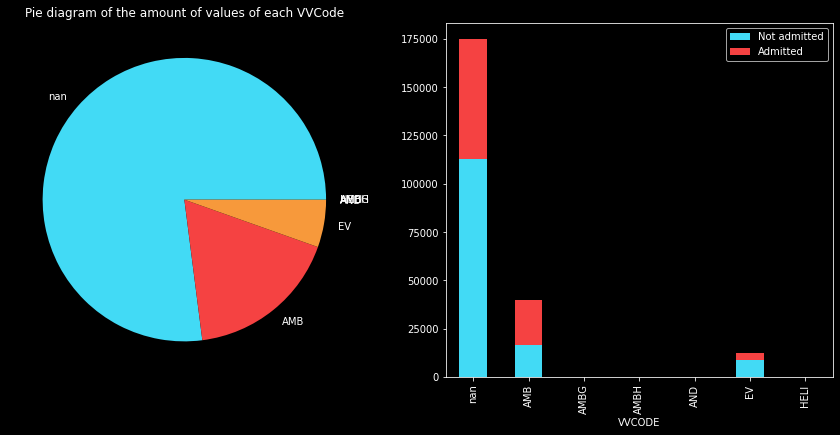

In [62]:
val_counts = df['VVCODE'].value_counts(dropna=False)
print(val_counts)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Pie diagram of the amount of values of each VVCode')
plt.pie(val_counts, labels=val_counts.keys(), colors=[blue, red, orange, yellow, green, purple])

ax = plt.subplot(1, 2, 2)
df['VVCODE'].groupby(df['OPNAME']).value_counts(dropna=False).unstack(level=0).plot(kind='bar', stacked=True, ax=ax, color=[blue, red])
plt.legend(labels=['Not admitted', 'Admitted'], loc='best')

plt.tight_layout()
plt.show()

Most of the type of transport is unknown.  
Furthermore, some people got transported by ambulance or had own transportation.

#### Klacht


... NLP ...

#### Triage code

Te triage codes stand for:  
- U0 Failure of vital functions: initiate resuscitation.
- U1 Life-threatening, unstable vital signs:
- U2 Urgent, threat to vital functions
- U3 Urgent, real risk of physical or emotional damage:
- U4 Not urgent
- U5 No chance of damage


U3     96011
U2     61065
U1     25302
U5     23516
NaN    11597
U4      8743
U0       511
Name: TRIANIVCOD, dtype: int64


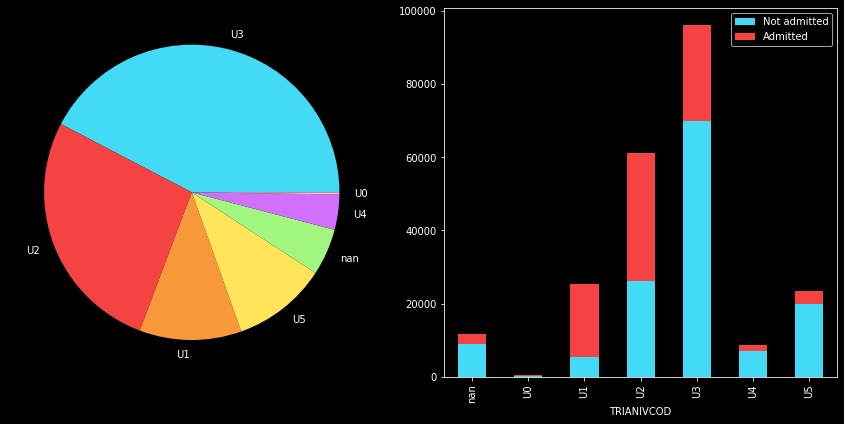

In [63]:
val_counts = df['TRIANIVCOD'].value_counts(dropna=False)
print(val_counts)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.pie(val_counts, labels=val_counts.keys(), colors=[blue, red, orange, yellow, green, purple, 'pink'])

ax = plt.subplot(1, 2, 2)
df['TRIANIVCOD'].groupby(df['OPNAME']).value_counts(dropna=False).unstack(level=0).plot(kind='bar', stacked=True, ax=ax, color=[blue, red])
plt.legend(labels=['Not admitted', 'Admitted'], loc='best')

plt.tight_layout()
plt.show()



The lower the traige code, the more serious the ED visit is according to triage.  
As can be seen most of the ED visits are classified as U3, which is the middle code.  
The U0 code is luckily rarely given to patients.  
The data also contains some NA values, lets see which records these are.

In [64]:
# df[df['TRIANIVCOD'].isnull()]

There does not seem to be a reason why these are NaN values.  
Theyre probably just not entered.  
Maybe when we look at it with respect to the date, we can see something noteworthy.  

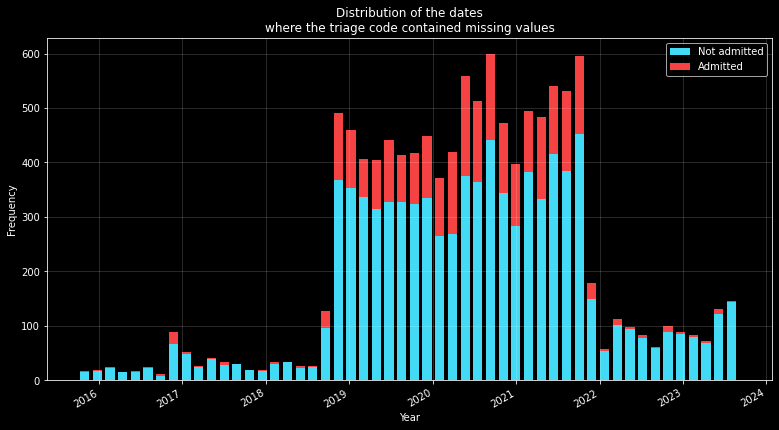

In [65]:
from datetime import datetime

plt.figure(figsize=(13, 7))
plt.title('Distribution of the dates\nwhere the triage code contained missing values')
plt.xlabel('Year')
plt.ylabel('Frequency')

colors = [blue, red]

date_range = (min(df['AANKSDATUM']), max(df['AANKSDATUM']))

bottom = 0
for i, categorie in enumerate(df['OPNAME'].unique()):
    subset = df[(df['OPNAME'] == i) & (df['TRIANIVCOD'].isnull())]['AANKSDATUM']
    hist_values, _, _ = plt.hist(subset, bins=52, range=date_range, width=40, color=colors[i], bottom=bottom, label=categorie)
    bottom = hist_values  # start value, so that it is stacked

plt.gcf().autofmt_xdate()
plt.legend(labels=['Not admitted', 'Admitted'], loc='best')
plt.grid(alpha=.2)
plt.show()


Interesentingly It seems that in the period of 2029-2022 a lot of missing values.  
Additionaly, the period before 2019 did not contain that much missing values.  
Reasoning behind this is not clear, but is good to keep in mind.  

#### Specialisme

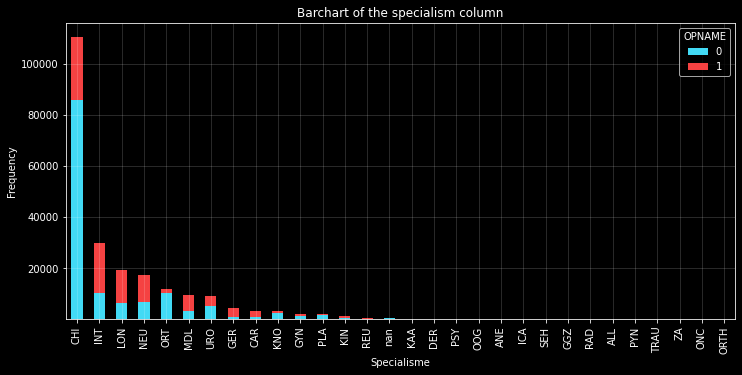

In [66]:
sorter = df['SPECIALISM'].value_counts(dropna=False)  # sorter for barchart to sort on amount of values per cat

plt.figure(figsize=(12, 12))

ax = plt.subplot(2, 1, 1)
plt.title('Barchart of the specialism column')
plt.xlabel('Specialisme')
plt.ylabel('Frequency')
df['SPECIALISM'].groupby(df['OPNAME']).value_counts(dropna=False).unstack(level=0).reindex(sorter.keys()).plot(kind='bar', stacked=True, ax=ax, color=[blue, red])
plt.grid(alpha=.2)


value_counts = df.groupby(['SPECIALISM', 'OPNAME']).size().unstack(fill_value=0)
# calculate the percentage for each 'OPNAME' category within each 'AANKSTIJD' category
percentage_per_spec = value_counts.div(value_counts.sum(axis=1), axis=0) * 100
percentage_per_spec = percentage_per_spec.reindex(sorter.keys()).dropna()

As you can see CHI makes up most of the data. CHI probably stands for Chirurgie.  
We again got some NaN values, lets look at that.

In [67]:
# df[df['SPECIALISM'].isnull()]


There does not seem to be a pattern in the missing values.  


#### Bestemming

This is our target value for modeling.  
Where in the end it will be one hot encoded to a 1 if it is OPN and a 0 if it is not OPN.  
However, we can still have a look at the data.  

In [68]:
df['BESTEMMING'].value_counts(dropna=False)

NHG     112983
OPN      89259
NHCP     17058
OVER      3222
POLI      2584
NHCH       763
MOR        276
NHTA       273
VRPL       272
OVZO        52
OVNH         2
HAP          1
Name: BESTEMMING, dtype: int64

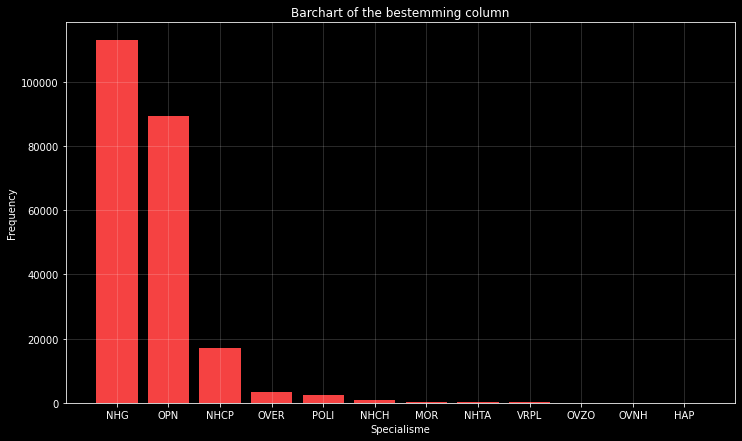

In [69]:
val_counts = df['BESTEMMING'].value_counts(dropna=False)

# we have a lot of categories, so making a pie diagram will be chaotic, so I made a barplot instead.
val_counts = val_counts.sort_values(ascending=False)  # sort values according to frequency
plt.figure(figsize=(12, 7))
plt.title('Barchart of the bestemming column')
plt.xlabel('Specialisme')
plt.ylabel('Frequency')
plt.bar(val_counts.keys(), height=val_counts, color=red)
plt.grid(alpha=.2)
plt.show()

As you can see most of this categories is made up from NHG, OPN and NHCP.  
These abbreviations probably stand for Naar Huis Gestuurd, Opname, Naar Huis Controle Poli, respectively.  
Lets see what the balance of OPN is, with respect to the other categories.

In [70]:
val_counts = df['BESTEMMING'].value_counts()  # no dropna because these will be discarded in the end
OPN = val_counts['OPN']
not_OPN = val_counts.sum() - OPN

print(f'OPN     = {OPN / (OPN + not_OPN) * 100 : 3g}%')
print(f'not OPN = {not_OPN / (OPN + not_OPN) * 100 : 3g}%')

OPN     =  39.3654%
not OPN =  60.6346%


The classes are somewhat imbalanced. 

#### NaN values

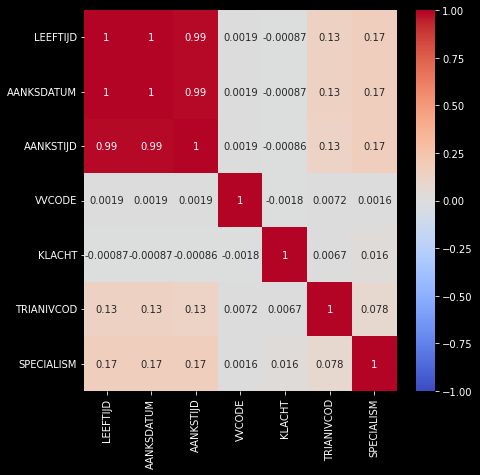

In [71]:
na_df = df.isna()
for col in na_df:
    if na_df[col].sum() == 0:
        na_df = na_df.drop(col, axis=1)

plt.figure(figsize=(7, 7))    
sns.heatmap(na_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()